# Домашнее задание к занятию 2.1: Деревья решений. Классификация

## Обзор прошедшего занятия

Что мы делали в классе:

**Задание 1**
* строили деревья
* критерии информативности которых написали даже сами
* визуализировали границы принятия решений в 2d
* и рисовали сами деревья


**Задание 2**
* приняли участие в соревновании на Kaggle, переварив кучу текстовых фичей в численные, проведя кросс-валидацию и сделав сабмит


**Задание 3**
* построили руками несколько метрик качества бинарной классификации


**Задание 4**
* использовали их для оценки классификации разделения статей Ведомостей по топикам

*дополнительно было много приятных ништяков. Например, облако слов, мультипоточность в целях парсинга, удобный инструмент для нахождения правильной css разметки, сохранение моделей в статичные файлы, разделение строк на слова и лемматизация этих слов*

## Домашнее задание

**Lvl 1:**

* взять подготовленные раннее данные из задачи **Titanic**, обучиться на них с помощью дерева решений и кросс-валидации и сделать сабмит
* кросс-валидацию желательно сделать сразу по нескольким фичам ( параметр *grid* в *GridSearchCV* )
* определить самые важные фичи
* вывести дерево решений (можете попробовать установить pydot и webgraphviz для отрисовки деревьев внутри ноутбука)

**Результат:** скрины нового сабмита на Kaggle и построенного дерева

In [1]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from io import StringIO

import pydot

from IPython.display import Image

from matplotlib import pyplot as plt
%matplotlib inline

Загружаем данные

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Отделяем целевую функцию в отдельный объект, добавляем фичу описываюцую из какого набора строка и объеденяем два набора чтобы дальнейшие преобразования делать над одним набором

In [5]:
y_train = train.Survived
train.drop('Survived', axis=1, inplace=True)
train.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [6]:
train['is_test'] = False
test['is_test'] = True

In [7]:
data = pd.concat([train, test])

Производим label encoding, one hot encoding и удаляем ненужные фичи

In [8]:
data['is_male'] = data.Sex.replace({"male": 1, "female":0})
data = pd.get_dummies(data, columns=['Pclass', 'Embarked'])

In [9]:
#перед удалением перекидываем в сабмит
submit = data[data.is_test][["PassengerId"]]

In [10]:
data.drop(["PassengerId", "Sex", "Cabin", "Ticket", "Name"], axis=1, inplace=True)

Далее делим на обучающую и тестовую выборки удалив вспомогательный столбец

In [11]:
X_train = data[~data.is_test].drop('is_test', axis=1)
X_test = data[data.is_test].drop('is_test', axis=1)

Заполняем пустые значение средним. Среднее считаем только по обучающей выборке

In [12]:
imputer = SimpleImputer( strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

Обучаемся с помощью дерева решений с помощью кросс-валидации меняем гиперпараметры модели

In [13]:
params = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : np.arange(1, 20),
    'min_samples_split' : np.arange(2, 4)
}
model = GridSearchCV(DecisionTreeClassifier(), params, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)

In [14]:
%%time

model.fit(X_train, y_train)

Fitting 5 folds for each of 152 candidates, totalling 760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  71 tasks      | elapsed:    4.1s


Wall time: 5.88 s


[Parallel(n_jobs=-1)]: Done 760 out of 760 | elapsed:    5.8s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9

In [15]:
model.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 2,
 'splitter': 'random'}

In [16]:
model.best_score_

0.8181818181818182

Подготавливаем сабмит

In [17]:
submit['Survived'] = model.predict(X_test)
submit.to_csv('titanic/submission.csv', index=False)

Важность фичей

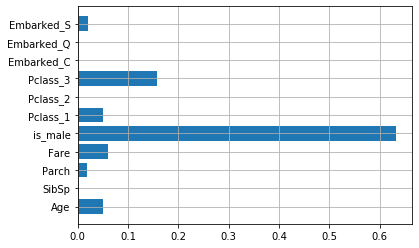

In [18]:
estimator = model.best_estimator_

plt.barh(np.arange(len(estimator.feature_importances_)), estimator.feature_importances_)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns)
plt.grid()
plt.show()

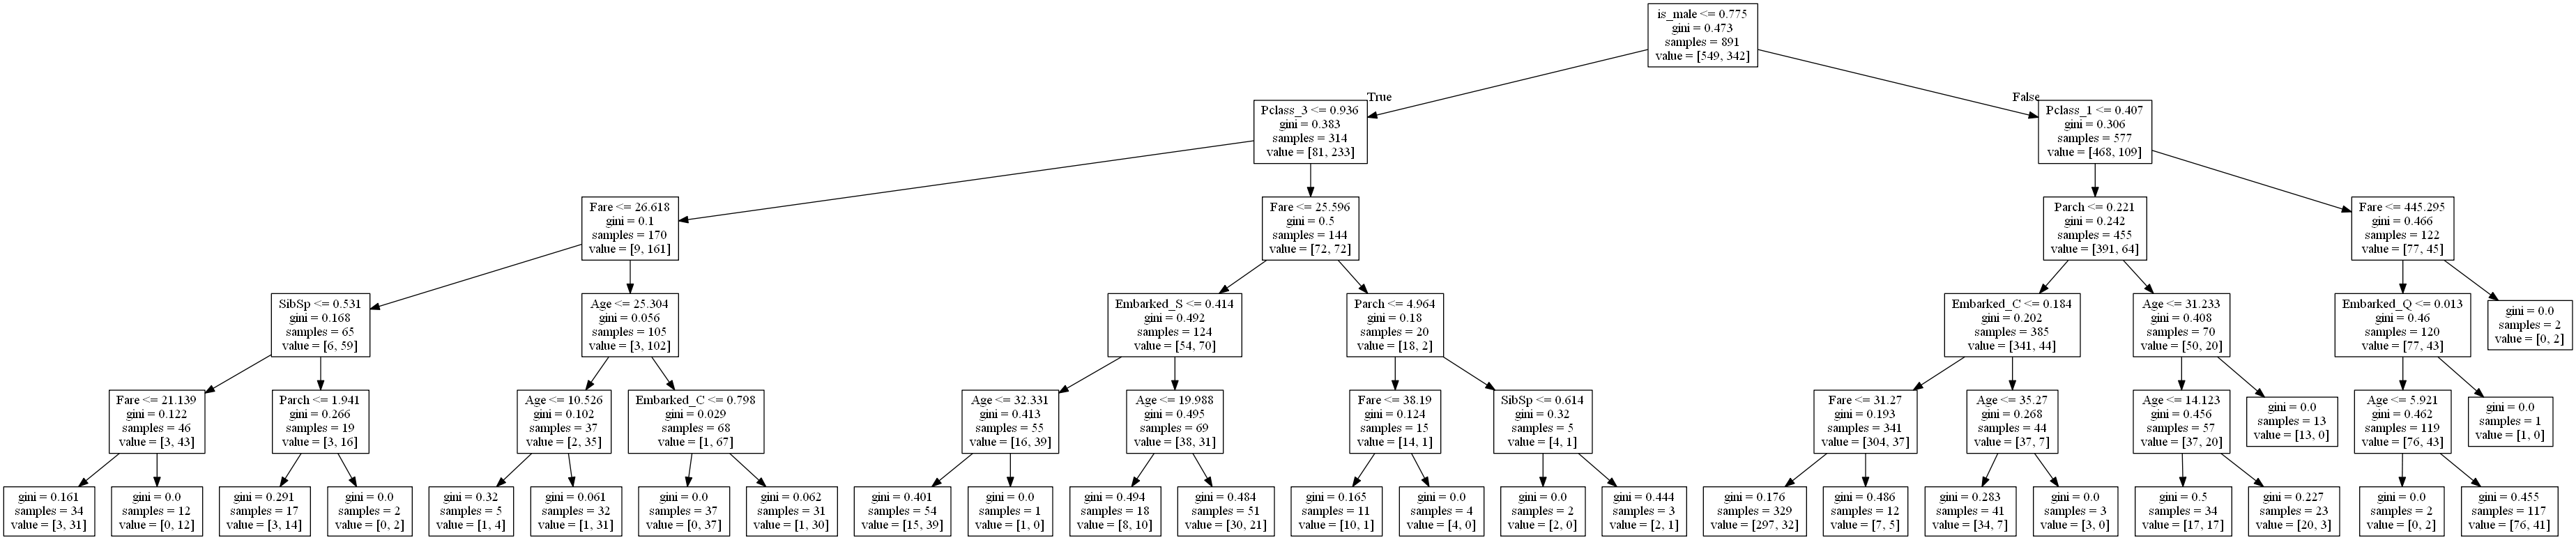

In [19]:
dot_data = StringIO()  
export_graphviz(estimator, out_file=dot_data, feature_names=X_train.columns)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())
png = graph[0].create_png()
type(png)

#write to file
with open('titanic/decision_tree.png', 'wb') as f :
    f.write(png)
    
# and show
Image(png)

**Lvl 2:** (опционально)

* С помощью функций sklearn.metrics.auc, precision, recall составить функцию для расчёта ROC-AUC, ROC-PRC
* Придумать себе интересную задачу на основе данных из интернета =) Спарсить ещё какой-нибудь сайт (не Ведомости) и решить задачу классификации. Делать свои проекты - круто. Если будут - кидайте мне =) [@NikitaKuznetsov](http://t.me/NikitaKuznesov)